### imports and setup

In [6]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [7]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, lorenzDatasetWrapper, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

In [9]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


### check data

#### predict from X1 & X2 input window

In [10]:
# only uncomment each line if testing a non-default parameter
dataset_x1x2window = lorenzDataset(
    predict_from="X1X2_window",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
    override=True)


generating new Lorenz data and saving to file
generating window data
total steps: 400
starting integration


NameError: name 'lorenz_df' is not defined

In [ ]:
train_x1x2window = dataset_x1x2window[:int(0.8 * dataset_x1x2window.n_graphs)]
val_x1x2window = dataset_x1x2window[int(0.8 * dataset_x1x2window.n_graphs):]

In [ ]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x1x2window.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.003489
time to get std&mean from X1: 0:00:00.005992
time to get std&mean from X2: 0:00:00.003510
time to get means: 0:00:00.014599
time to normalize data: 0:00:00.017436


In [ ]:
print(type(train_x1x2window))
train_x1x2window.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X1X2_window',
 'n_samples': 100,
 'input_steps': 200,
 'output_steps': 1,
 'output_delay': 100,
 'min_buffer': -300,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

In [ ]:
print(train_x1x2window[0])
print(train_x1x2window[0].x.shape)
print(train_x1x2window[0].y.shape)

Graph(n_nodes=36, n_node_features=400, n_edge_features=None, n_labels=1)
(36, 400)
(36, 1)


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


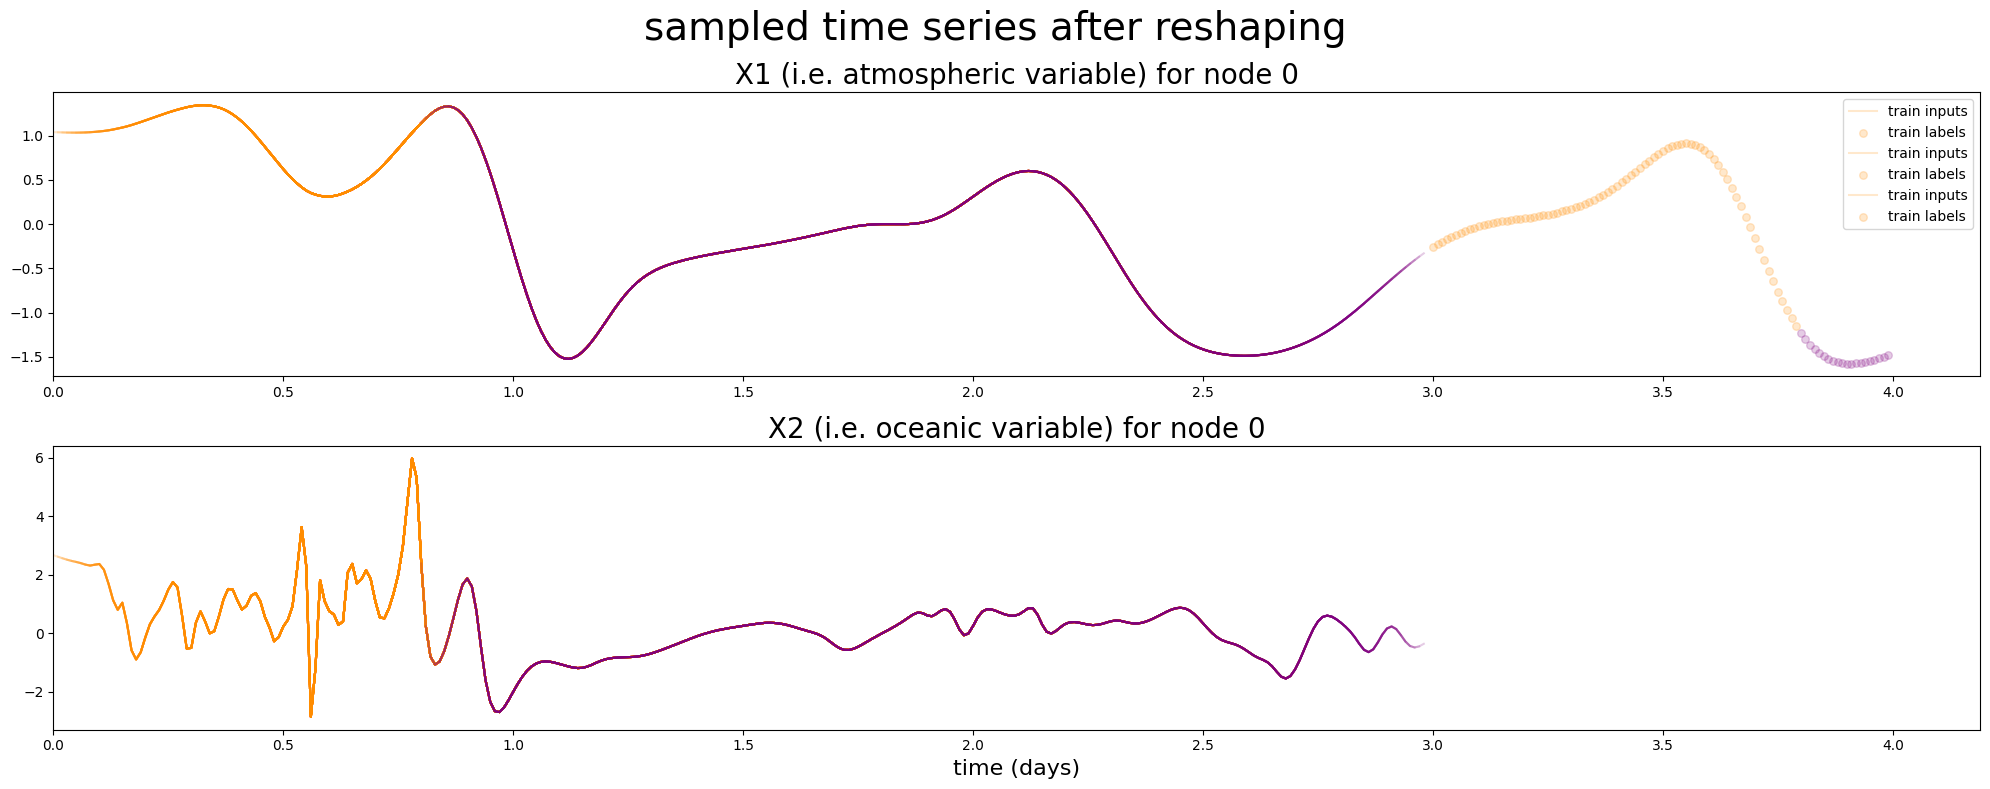

In [ ]:
fig, (ax0, ax1) = plot_data(train_x1x2window, val_x1x2window, test=None, node=0)

plt.tight_layout()
plt.show()

#### predict from X2 (single value)

In [ ]:
# only uncomment each line if testing a non-default parameter
dataset_x2single = lorenzDataset(
    predict_from="X2",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    override=True)


generating new Lorenz data and saving to file
generating paired data
starting integration
reading Lorenz data from stored file


In [ ]:
train_x2single = dataset_x2single[:int(0.8 * dataset_x2single.n_graphs)]
val_x2single = dataset_x2single[int(0.8 * dataset_x2single.n_graphs):]

In [ ]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x2single.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.000438
time to get std&mean: 0:00:00.000896
time to get means: 0:00:00.002116
time to normalize data: 0:00:00.002472


In [ ]:
print(type(train_x2single))
train_x2single.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X2',
 'n_samples': 100,
 'input_steps': 1,
 'output_steps': 1,
 'output_delay': 0,
 'min_buffer': 0,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

In [ ]:
print(train_x2single)
print(train_x2single[0])
print(train_x2single[0].x.shape)
print(train_x2single[0].y.shape)

lorenzDataset(n_graphs=80)
Graph(n_nodes=36, n_node_features=1, n_edge_features=None, n_labels=1)
(36, 1)
(36, 1)


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


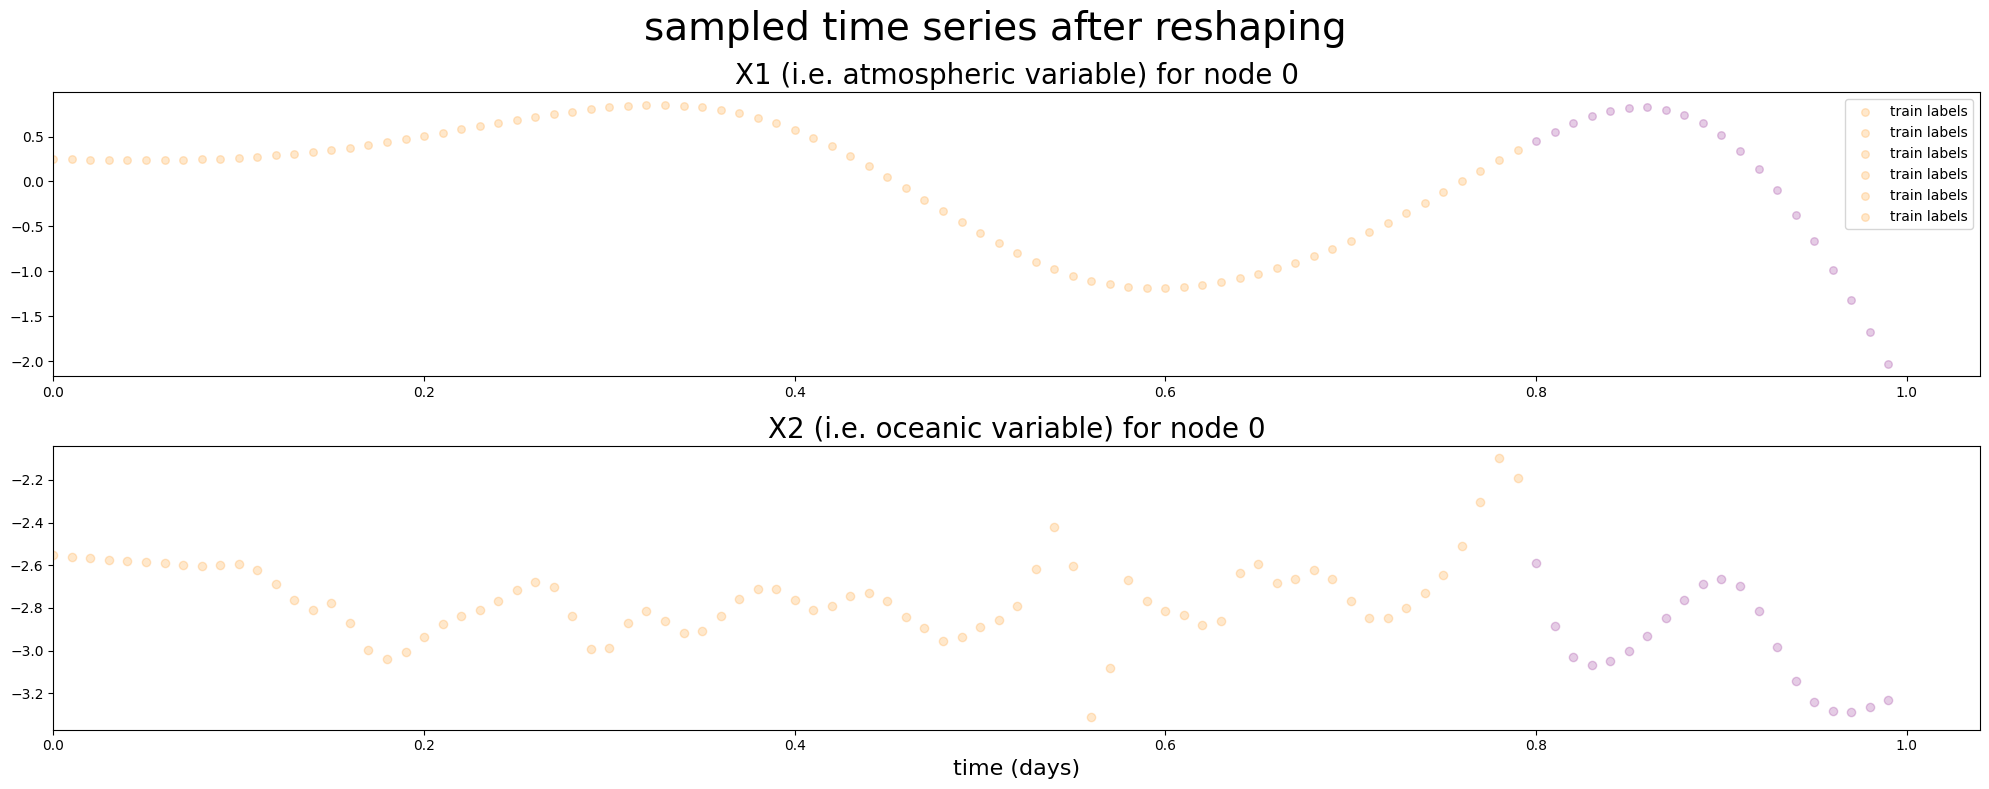

In [ ]:
fig, (ax0, ax1) = plot_data(train_x2single, val_x2single, test=None, node=0)

plt.tight_layout()
plt.show()

### predict from X2 using buffer

In [101]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    h=0.1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=900,
    return_buffer=True,
    train_pct=0.7,
    val_pct=0.2,
    test_pct=0.1,
    override=True)


generating new Lorenz data and saving to file
generating paired data
starting integration
reading Lorenz data from stored file
dataset_raw lorenzDataset(n_graphs=1000)
time to concat: 0:00:00.005114
time to get std&mean: 0:00:00.005406


In [102]:
print(dataset.train.a.todense())

[[1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]]


In [103]:
dataset.buffer

lorenzDataset(n_graphs=900)

In [104]:
dataset.train

lorenzDataset(n_graphs=70)

In [105]:
dataset.val

lorenzDataset(n_graphs=20)

In [106]:
dataset.test

lorenzDataset(n_graphs=10)

In [107]:
print(dataset.train)
print(dataset.train[0])
print(dataset.train[0].x.shape)
print(dataset.train[0].y.shape)

lorenzDataset(n_graphs=70)
Graph(n_nodes=36, n_node_features=1, n_edge_features=None, n_labels=1)
(36, 1)
(36, 1)


plotting train
plotting val
plotting test
editing legend


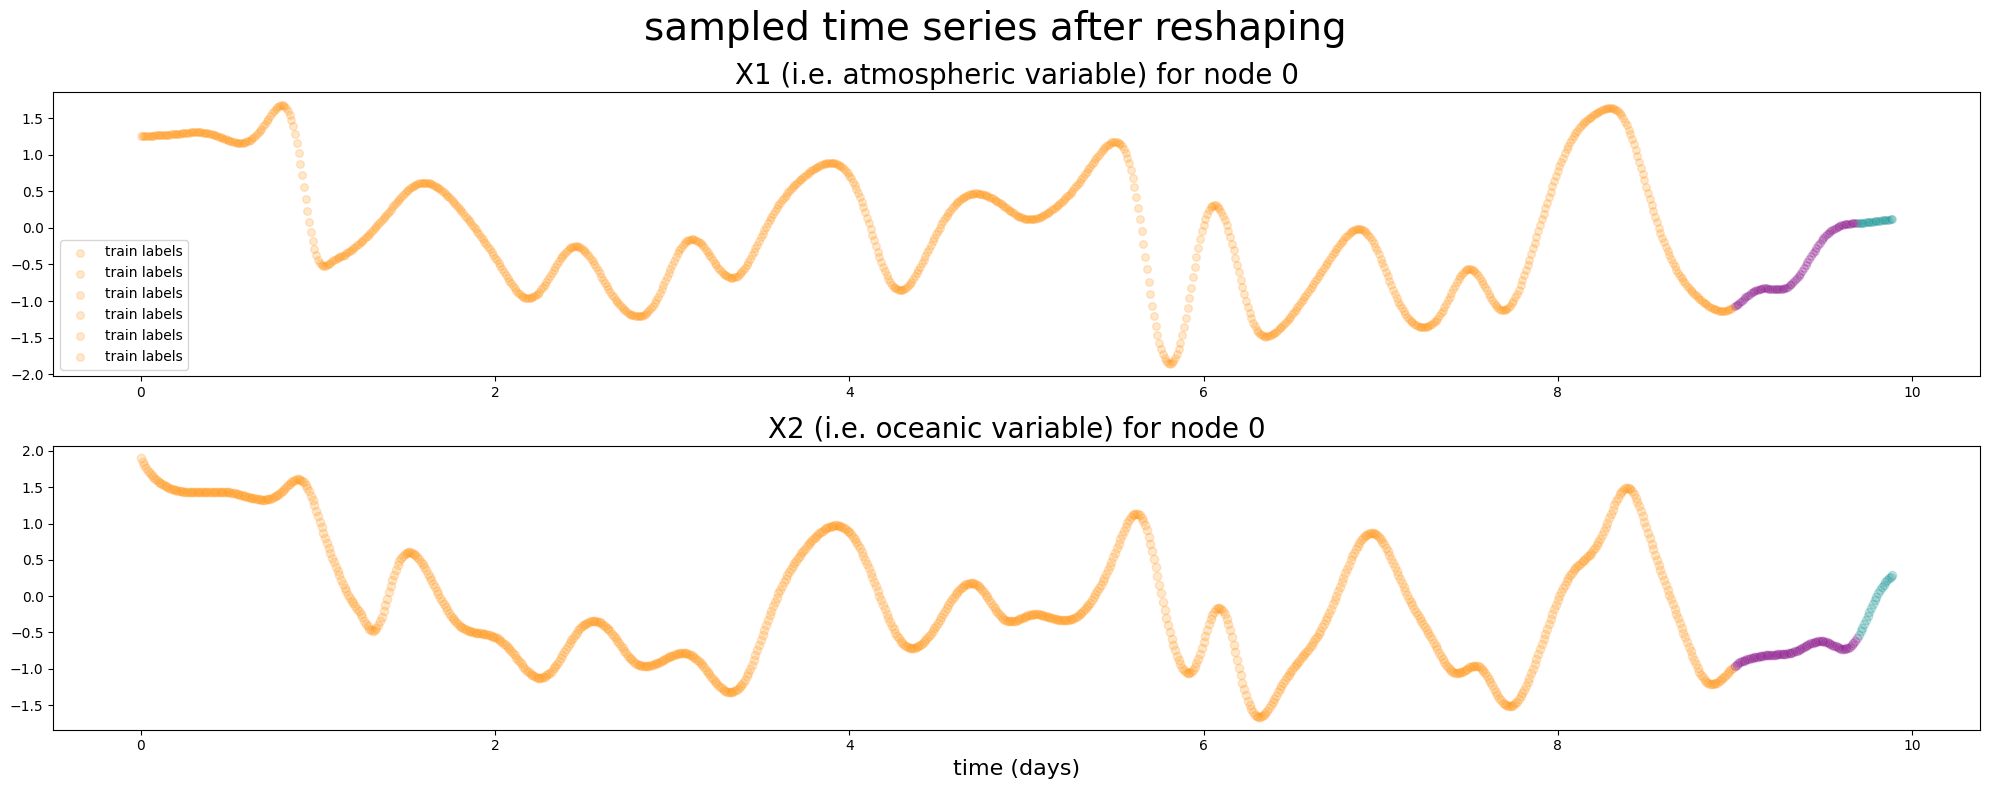

In [108]:
fig, (ax0, ax1) = plot_data(dataset.buffer,
                            dataset.train,
                            test=dataset.val,
                            node=0)
plt.tight_layout()
plt.show()

plotting train
plotting val
plotting test
editing legend


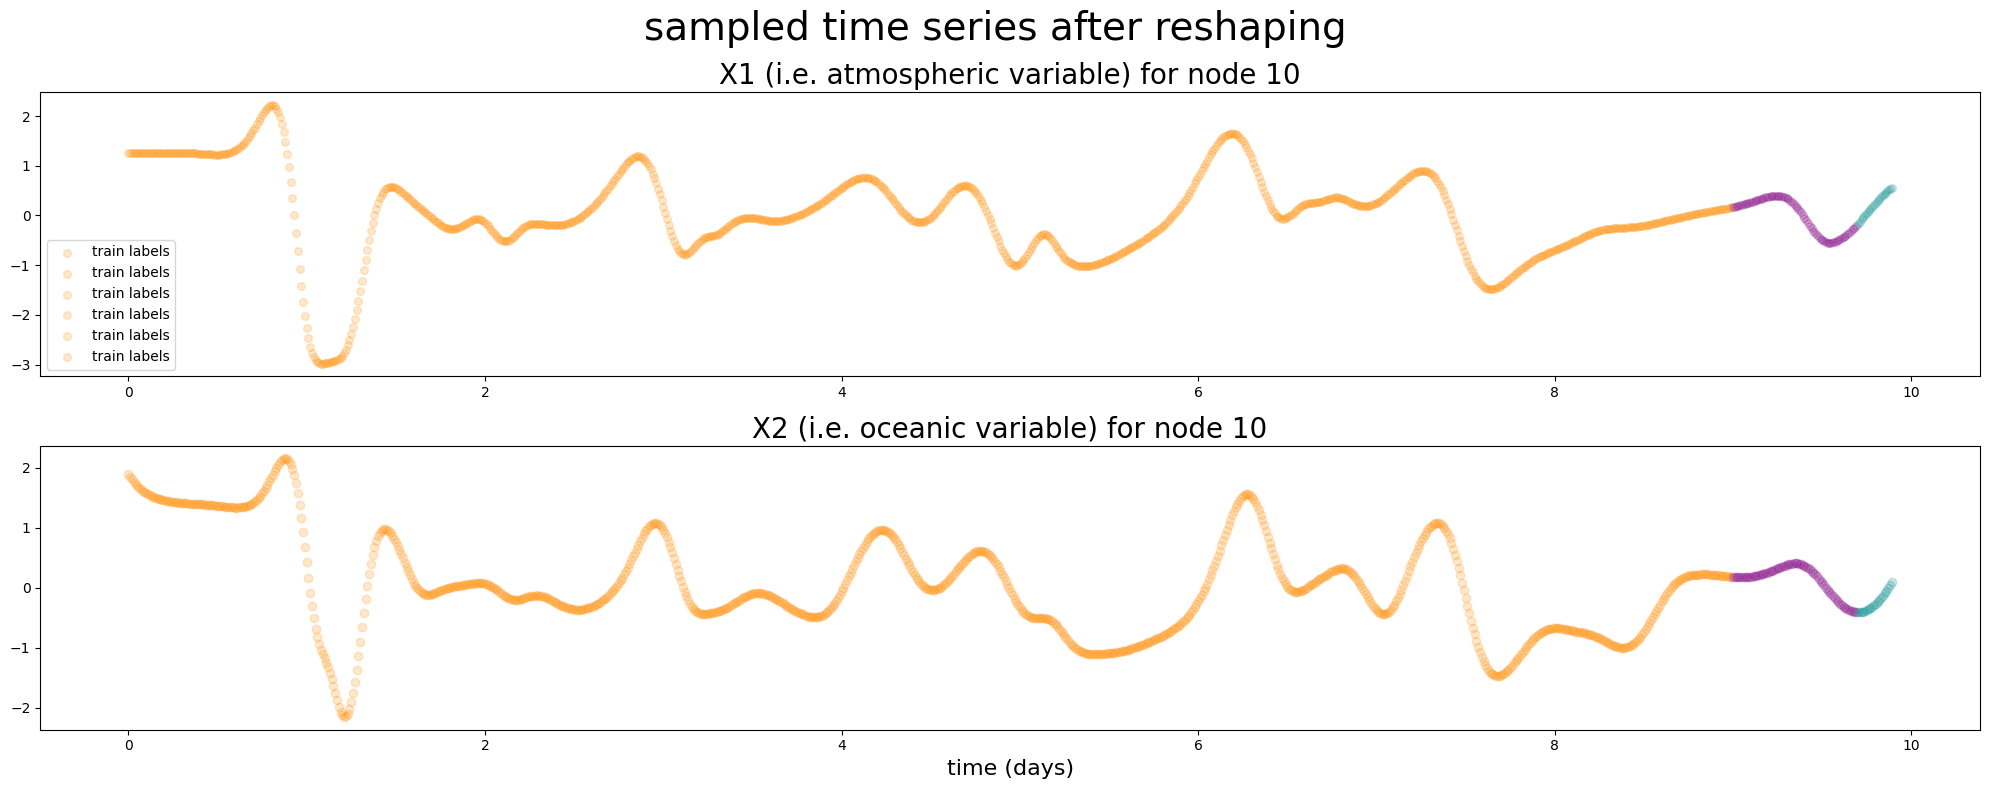

In [109]:
fig, (ax0, ax1) = plot_data(dataset.buffer,
                            dataset.train,
                            test=dataset.val,
                            node=10)
plt.tight_layout()
plt.show()

plotting train
plotting val
plotting test
editing legend


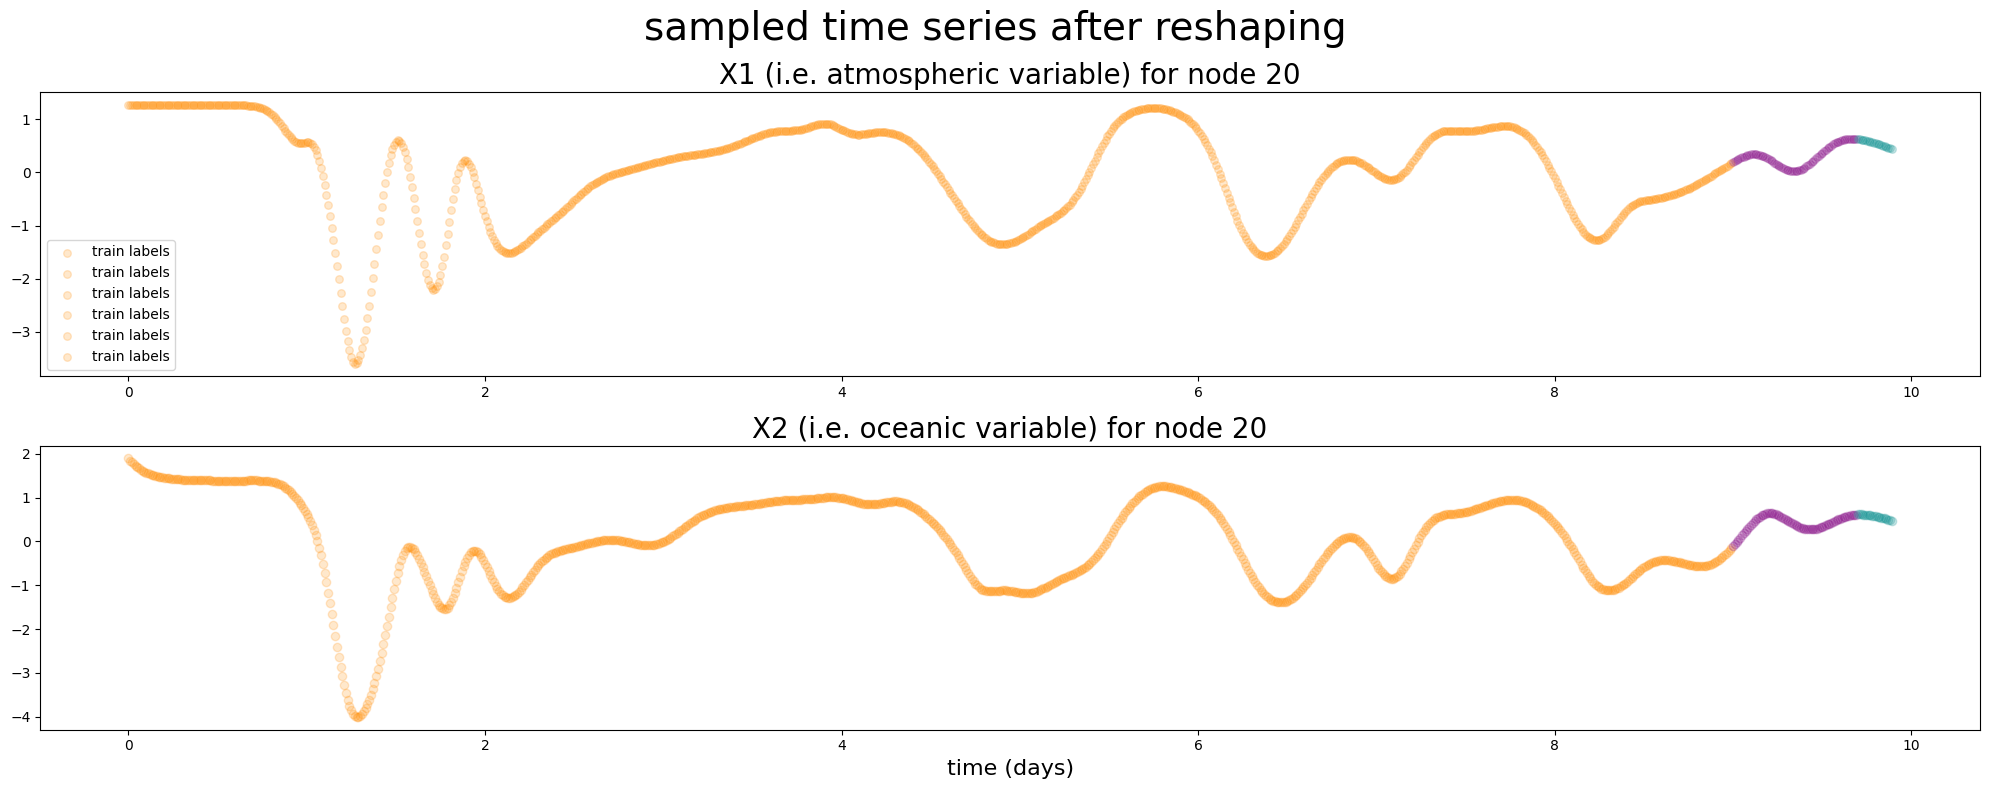

In [110]:
fig, (ax0, ax1) = plot_data(dataset.buffer,
                            dataset.train,
                            test=dataset.val,
                            node=20)
plt.tight_layout()
plt.show()

#### predict from X2 input window

In [ ]:
# TODO: update plotting code

## run 2-layer GCN

### X1X2 window

In [ ]:
model_x1x2window, history_x1x2window, fname_x1x2window = make_train_GCN(
    train_x1x2window,
    val_x1x2window,
    activation="relu",
    epochs=5,
    eval_val=True,
    tensorboard=True)


Epoch 1/5
3/3 [==============================] - 1s 144ms/step - loss: 89.1506 - val_loss: 11.5820
Epoch 2/5
3/3 [==============================] - 0s 37ms/step - loss: 72.5719 - val_loss: 5.4487
Epoch 3/5
3/3 [==============================] - 0s 35ms/step - loss: 52.0874 - val_loss: 3.4045
Epoch 4/5
3/3 [==============================] - 0s 36ms/step - loss: 47.6620 - val_loss: 3.5488
Epoch 5/5
3/3 [==============================] - 0s 37ms/step - loss: 43.5224 - val_loss: 3.7686


INFO:tensorflow:Assets written to: saved_models/gcn_3-20230221-104120/assets


INFO:tensorflow:Assets written to: saved_models/gcn_3-20230221-104120/assets


1/1 [==============================] - 0s 42ms/step


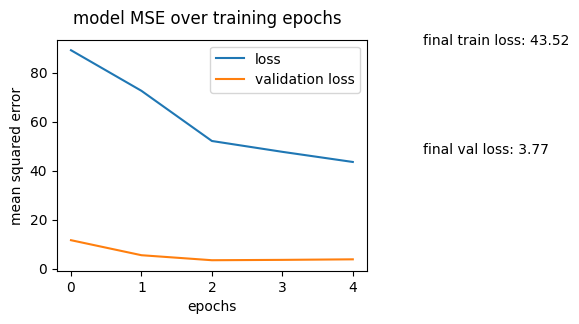

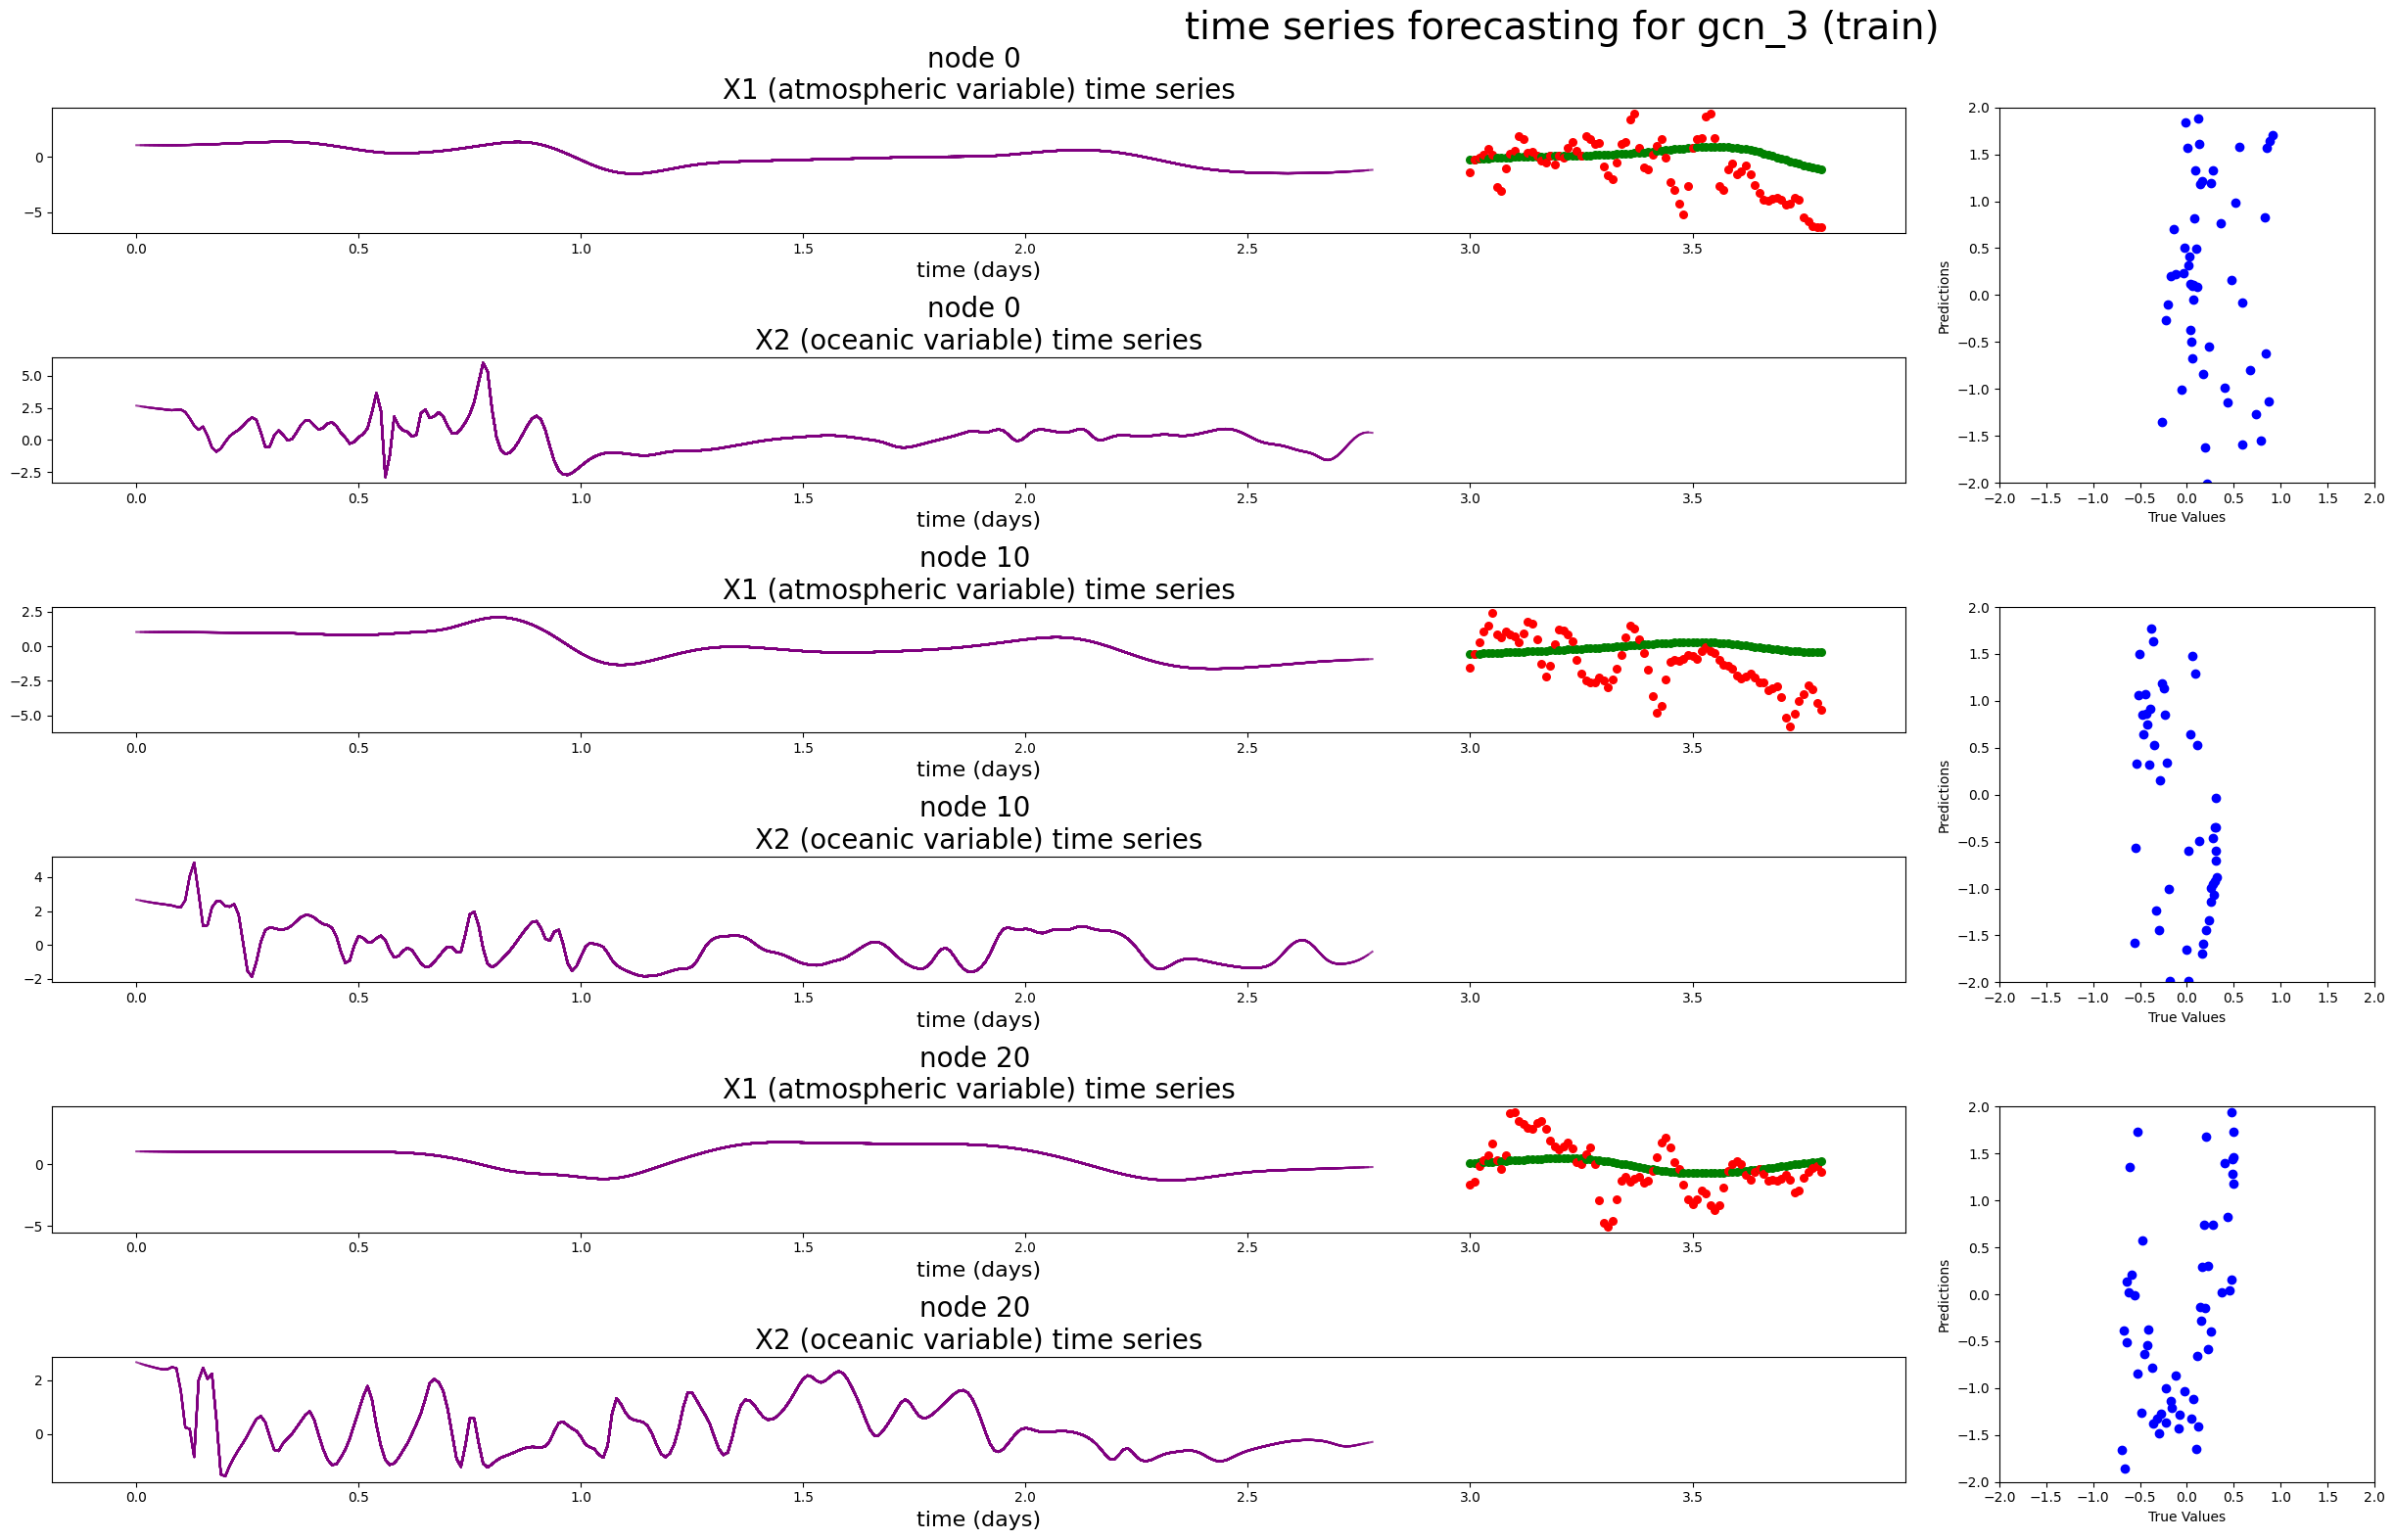

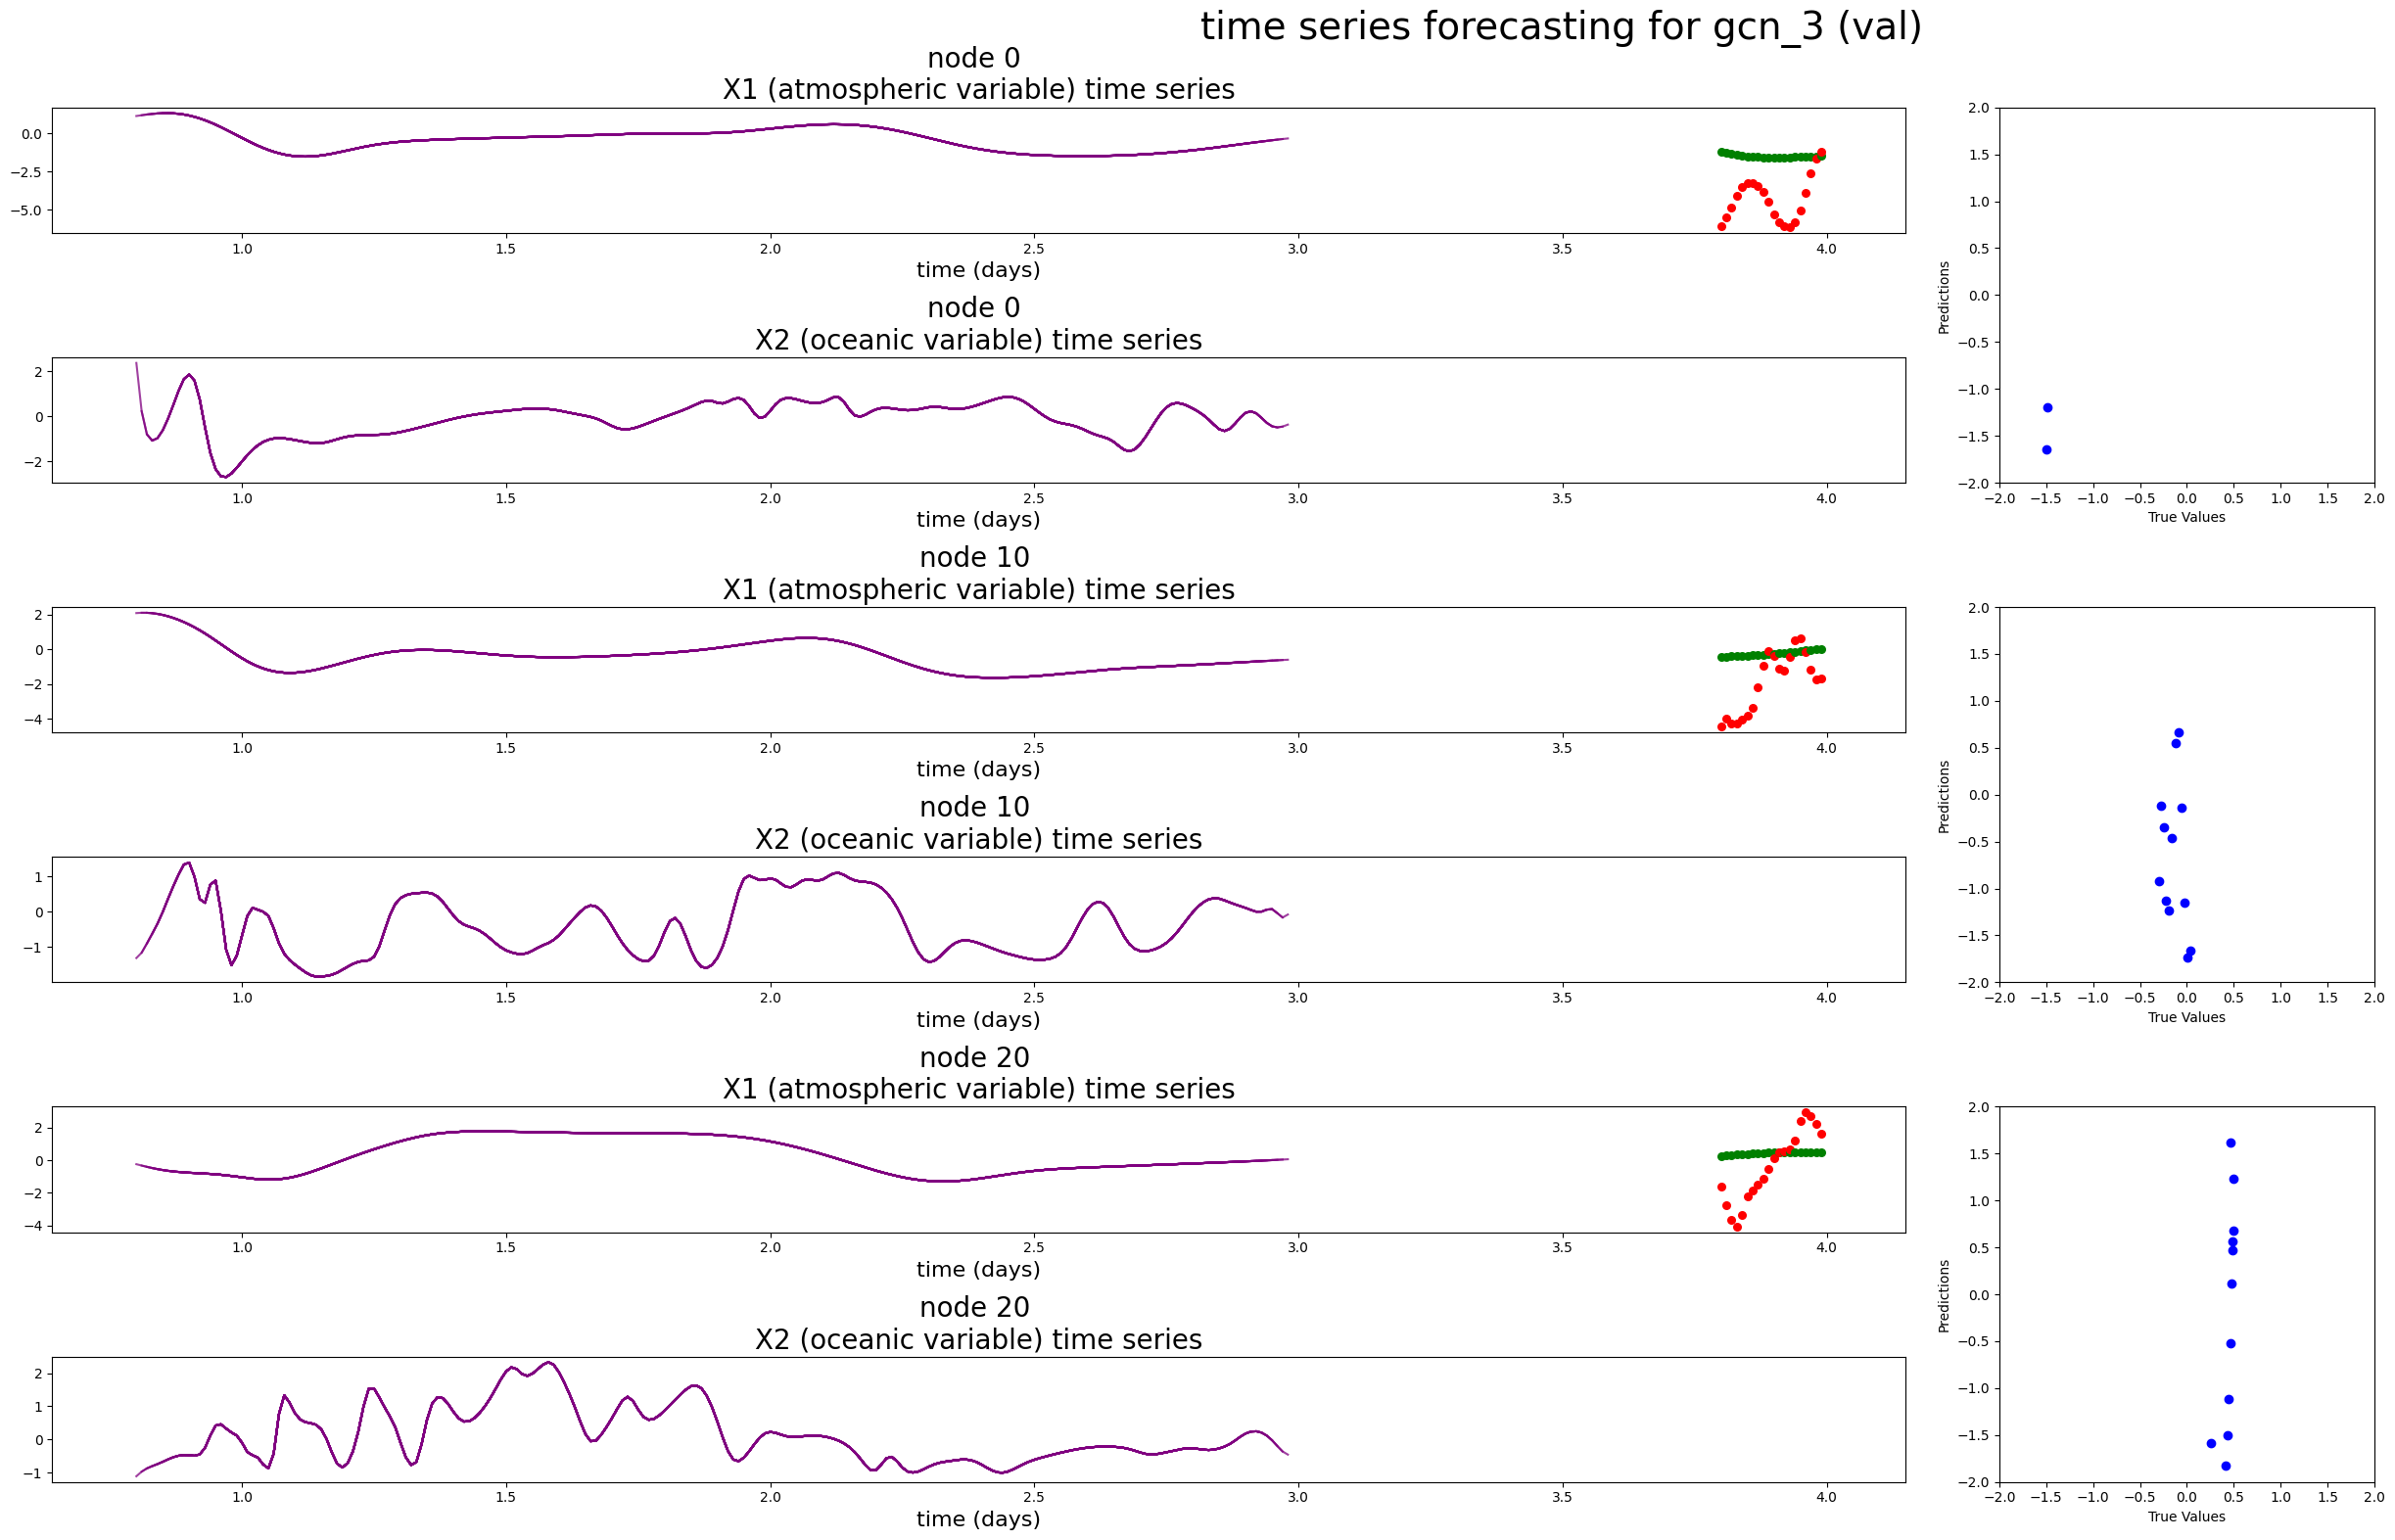

In [ ]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train_x1x2window,
    val_x1x2window,
    model_x1x2window,
    history_x1x2window,
    fname=fname_x1x2window,
    epochs=5)


### predict from X2_single

In [ ]:
model_x2single, history_x2single, fname_x2single = make_train_GCN(
    train_x2single,
    val_x2single,
    activation="relu",
    epochs=5,
    eval_val=True,
    tensorboard=True)


Epoch 1/5
3/3 [==============================] - 1s 135ms/step - loss: 1.6012 - val_loss: 5.3359
Epoch 2/5
3/3 [==============================] - 0s 28ms/step - loss: 1.4825 - val_loss: 4.9415
Epoch 3/5
3/3 [==============================] - 0s 27ms/step - loss: 1.3427 - val_loss: 4.5960
Epoch 4/5
3/3 [==============================] - 0s 28ms/step - loss: 1.2174 - val_loss: 4.3013
Epoch 5/5
3/3 [==============================] - 0s 29ms/step - loss: 1.2130 - val_loss: 4.0528


INFO:tensorflow:Assets written to: saved_models/gcn_4-20230221-104214/assets


INFO:tensorflow:Assets written to: saved_models/gcn_4-20230221-104214/assets


1/1 [==============================] - 0s 52ms/step


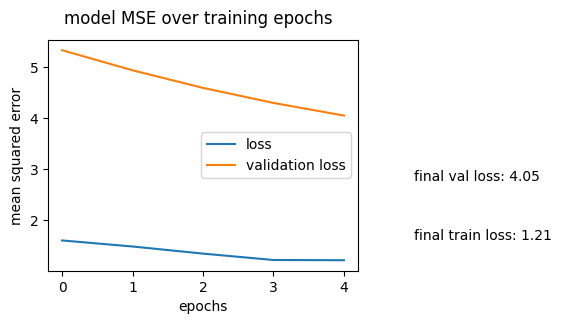

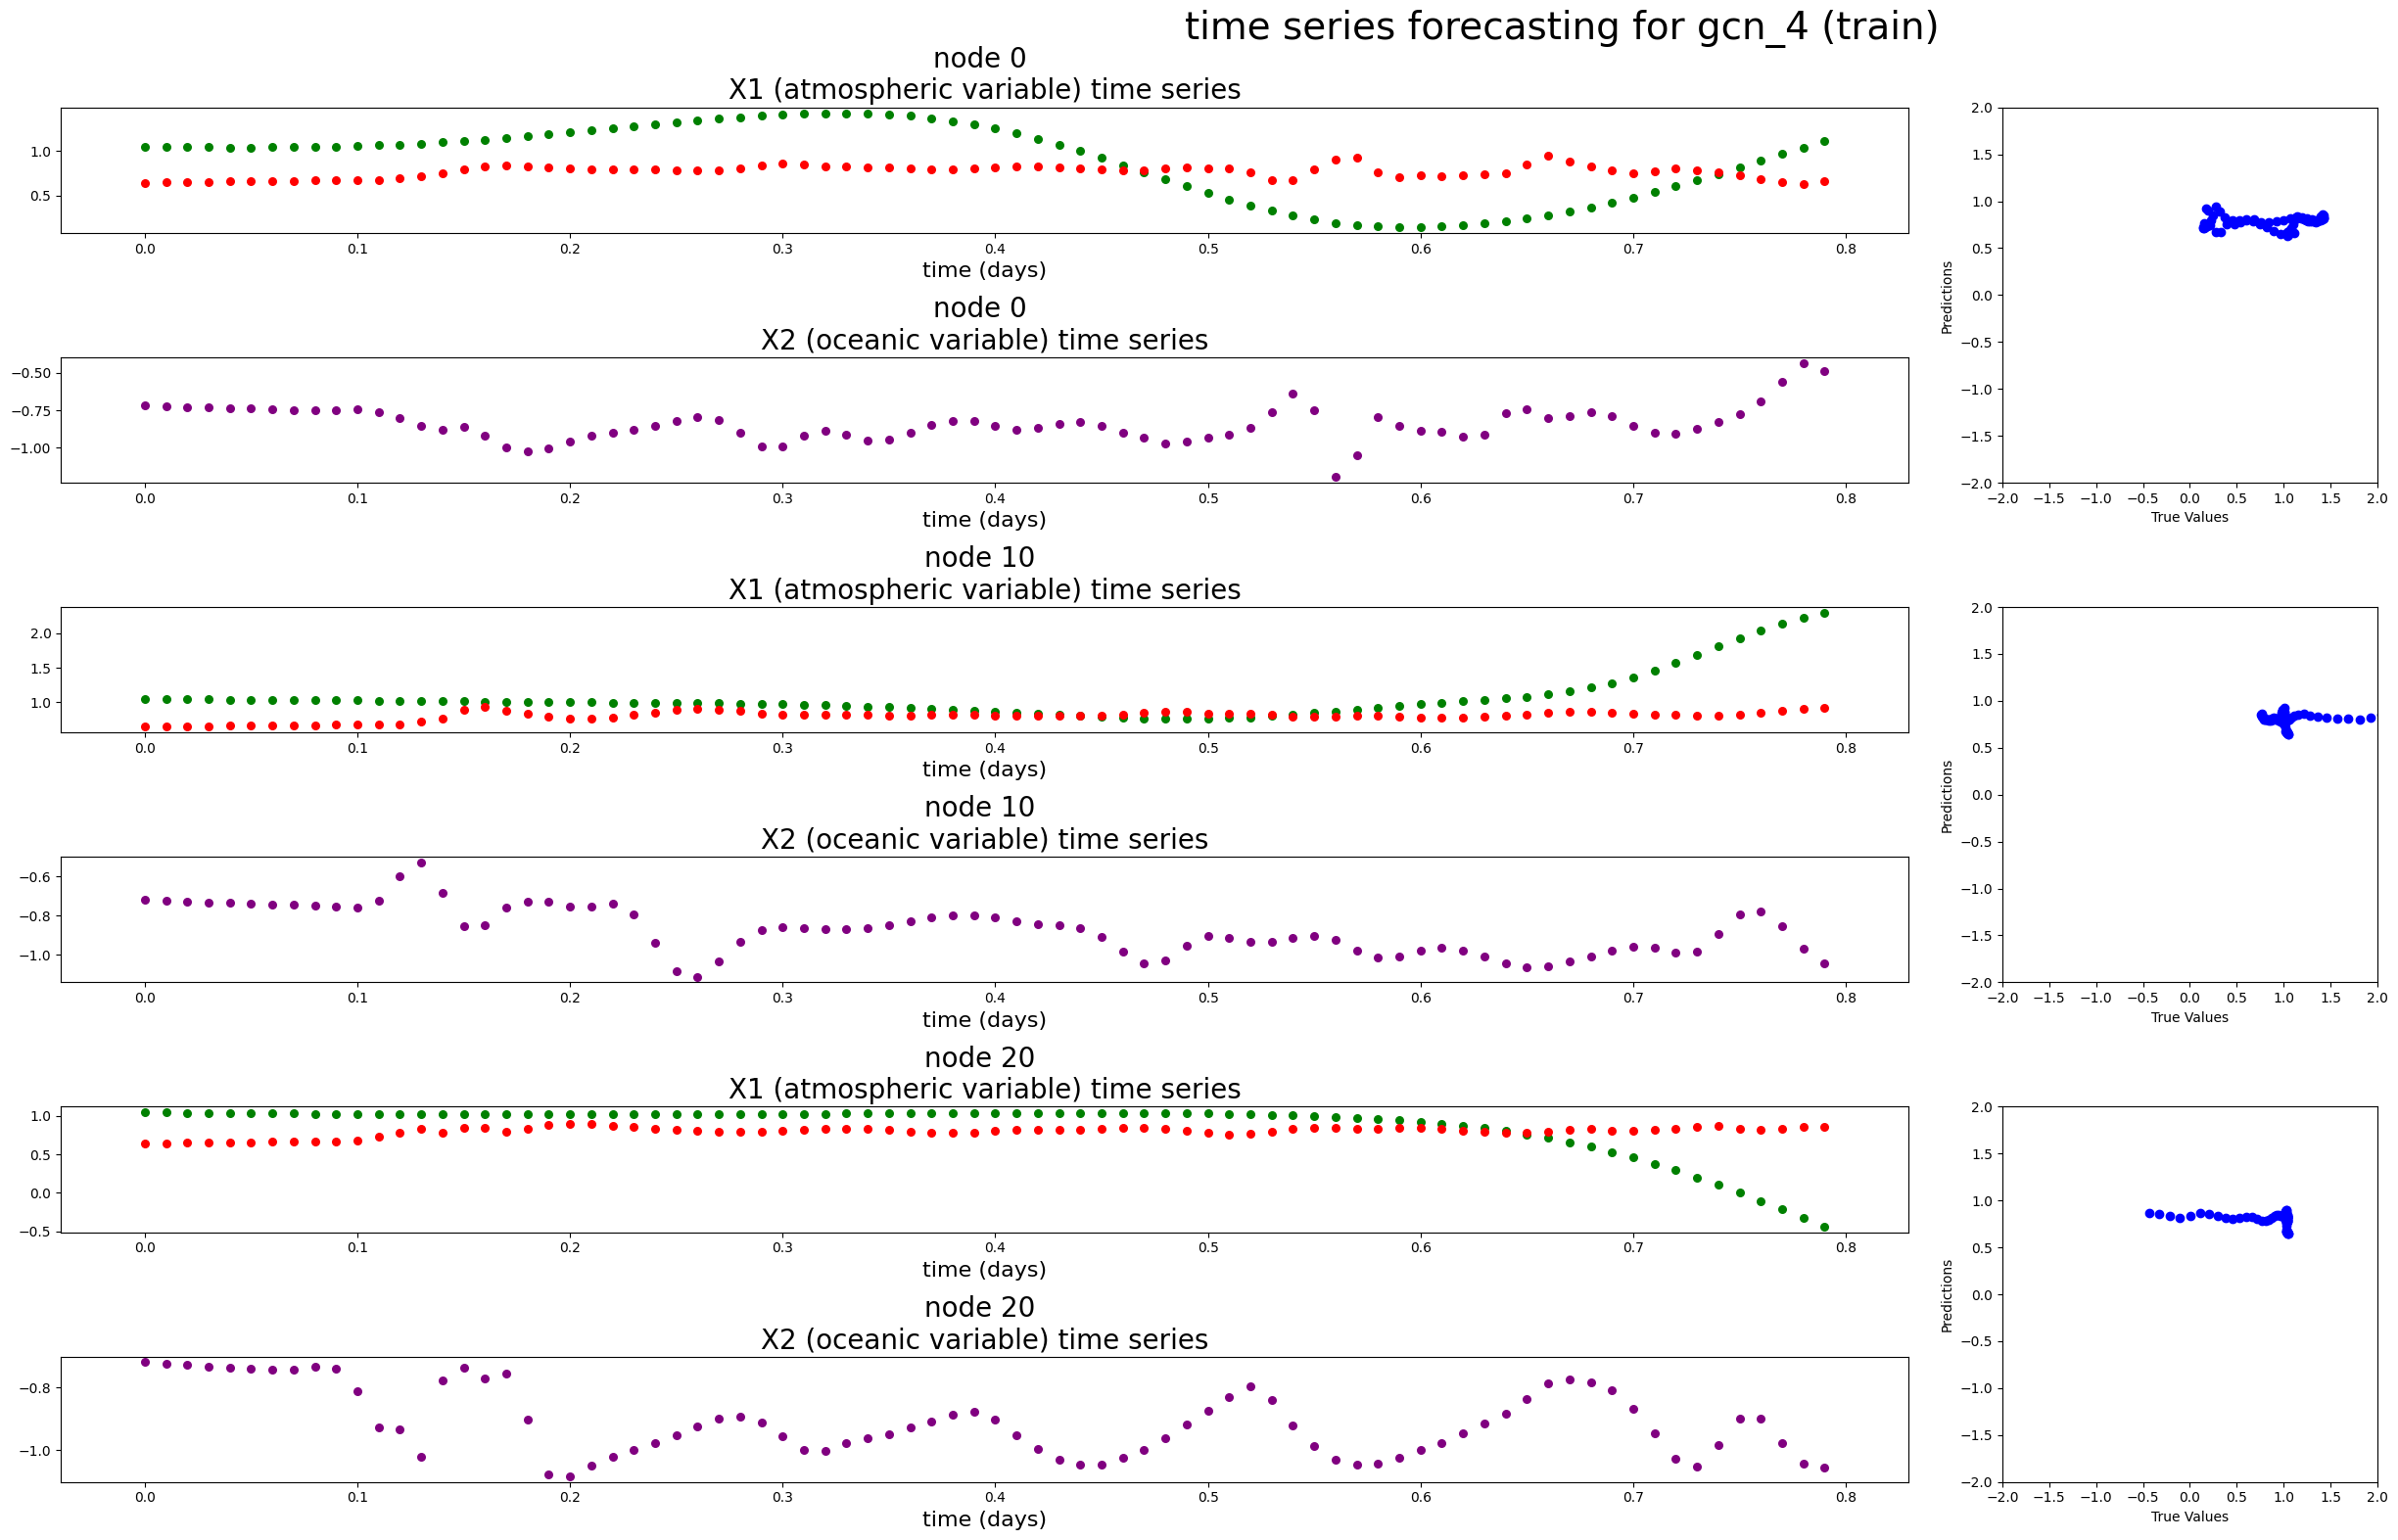

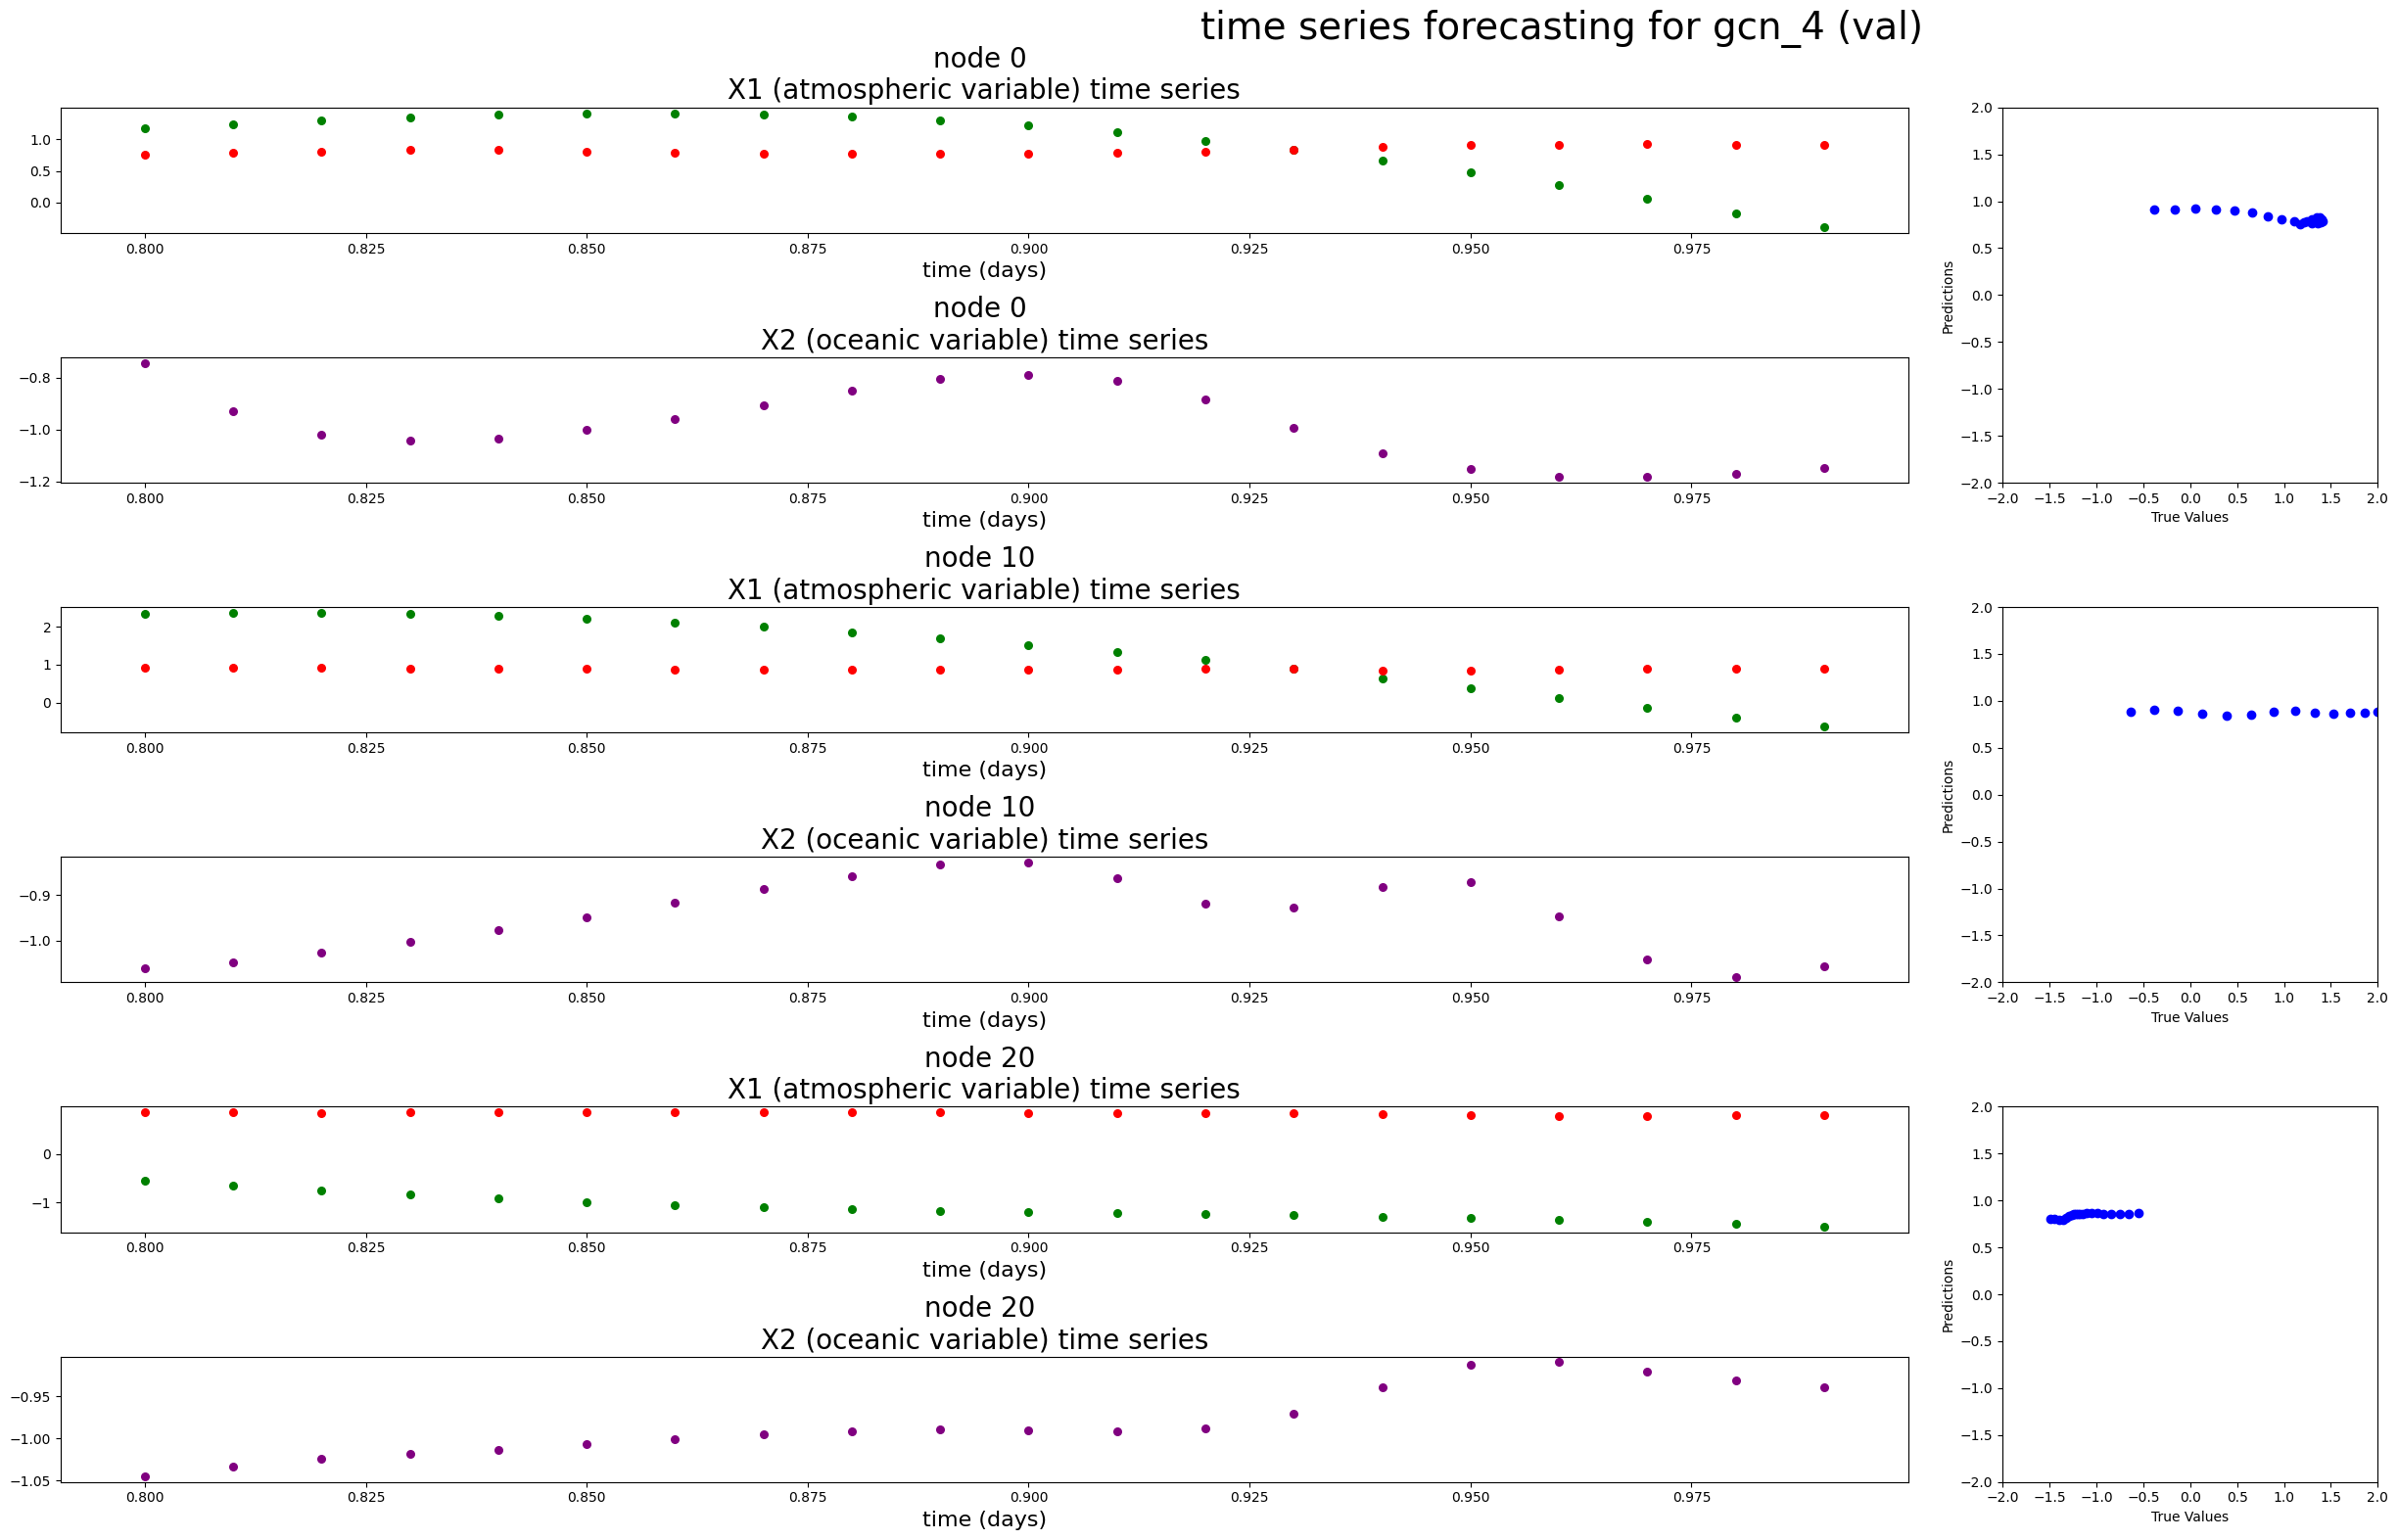

In [ ]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train_x2single,
    val_x2single,
    model_x2single,
    history_x2single,
    fname=fname_x2single,
    epochs=5)
